In [1]:
import pandas as pd
!pip install shapely

DEPRECATION: pandas 0.23.4 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%run ROUTINES/gauss_asym.py

In [3]:
%matplotlib widget

## Load fit info

In [4]:
#df_fits = pd.read_csv('fit_info/fit_sobrevivientes_rho_arm2.csv')

id_halo='289387'
df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv')
df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis = 1)
df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis = 1)

In [5]:
df_fits.tail(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
23,0.000040,9.842631,0.05,False,5.648160,23.0,1.026933,0.000003,0.038202,2.282778,0.109836,"[9.677090495998444, 9.749587874435312, 9.80120...",-8.492063,"[7.565842715364799e-06, 1.2476625988596912e-05...",-5.633117
24,0.000045,11.694272,0.05,False,-1.016509,24.0,0.782181,0.000002,0.329123,1.274429,0.249767,"[10.014933225287631, 10.20880392549769, 10.228...",-10.396825,"[4.885685546250429e-06, 9.077437626282172e-06,...",-4.651876
25,0.000049,12.555009,0.05,False,-0.000583,25.0,0.600929,0.000009,30948.745490,64550.204745,136.905597,"[10.993446105246349, 11.059463735411542, 11.32...",-11.955267,"[5.051148525056788e-06, 6.817175390383998e-06,...",-3.497475


In [6]:
params = df_fits.iloc[0] # Para investigar los resultado del fit de un punto, llamamos su fila en el DataFrame

In [7]:
params

amplitude                                                 1.24665e-05
center                                                        2.70845
delta                                                            0.05
fractured                                                       False
gamma                                                         -2.8975
id_tracing                                                          0
sigma                                                        0.411402
stderr_amplitude                                          8.69303e-07
stderr_center                                               0.0219939
stderr_gamma                                                  1.54426
stderr_sigma                                                0.0413968
x                   [1.5527010886672423, 1.591412618745411, 1.7299...
x_tracing                                                     2.53247
y                   [1.726008130602706e-06, 7.872130896135646e-07,...
y_tracing           

In [8]:
#import numpy as np

# Convertir las columnas 'x' y 'y' de cadenas a arrays numéricos
#params['x'] = np.array(params['x'].split('\\n'), dtype=float)
#params['y'] = np.array(params['y'].split('\\n'), dtype=float)

# Verificar los resultados
#print("X values:", params['x'])
#print("Y values:", params['y'])


In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [10]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



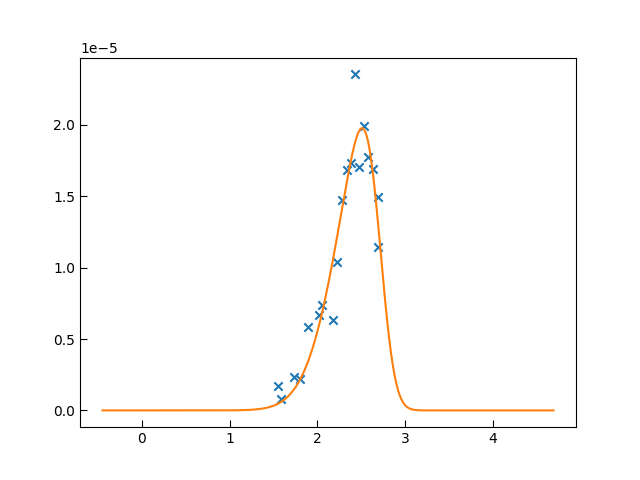

In [11]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficamos el fit y los puntos con los que se hizo el fit
fig, ax = plt.subplots()
ax.scatter(params.x, params.y, color = 'C0', marker = 'x') # Envoltorio
model_eval = eval_fitted_model_with_given_params(params, dx = 0.01) # Funcion en gauss_asym.py
x_eval = model_eval['x_eval']
y_eval = model_eval['y_eval']
ax.plot(x_eval, y_eval,color = 'C1'); # Fit

## Calculate width of a fit

In [12]:
%run ROUTINES/gauss_asym.py

In [13]:
dx = 0.001 # Discretizacion para mapear la gaussiana

In [14]:
width_info = find_widths_of_skewed_gaussian_dani(params, dx = dx) # Funcion en gauss_asym.py

In [15]:
width_info # Retorna la ubicacion del maximo (x_max, y_max) y el ancho a la izquierda (w1) y a la derecha (w2)

{'x_max': 2.510701088667245,
 'y_max': 1.9777063222836316e-05,
 'w1': 0.3523641276820335,
 'w2': 0.22996708656289977}

In [16]:
#fig, ax = plt.subplots(figsize=(10,5))
#plot_fit_and_widths(params, ax, dx = dx) # Funcion en gauss_asym.py

In [17]:
# Podemos aplicar find_widths_of_skewed_gaussian() a toda la tabla con la informacion de los parametros 

df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [18]:


df_fits.head(4)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000012,2.708450,0.05,False,-2.897497,0.0,0.411402,8.693027e-07,0.021994,1.544260,0.041397,"[1.5527010886672423, 1.591412618745411, 1.7299...",2.532468,"[1.726008130602706e-06, 7.872130896135646e-07,...",-0.611472,"{'x_max': 2.510701088667245, 'y_max': 1.977706...",2.510701,0.000020,0.352364,0.229967
1,0.000014,2.416738,0.05,False,1.448791,1.0,0.520256,1.042213e-06,0.119084,1.127943,0.120114,"[2.1141490788383095, 2.1965449812065927, 2.244...",2.070707,"[6.282016359325803e-06, 7.187771204181052e-06,...",-1.708153,"{'x_max': 2.698149078838312, 'y_max': 1.458177...",2.698149,0.000015,0.419311,0.478318
2,0.000021,2.616503,0.05,False,3.564727,2.0,0.493153,1.674766e-06,0.034669,1.587774,0.060571,"[2.384220426080411, 2.4480923083581936, 2.4928...",0.569986,"[4.817721435256505e-06, 8.130913256919182e-06,...",-2.747114,"{'x_max': 2.833220426080413, 'y_max': 2.927982...",2.833220,0.000029,0.241849,0.426316
3,0.000028,2.459819,0.05,False,9.366087,3.0,1.139568,1.985699e-06,0.026092,4.056319,0.123933,"[2.3981618426268545, 2.4219235793559752, 2.498...",-1.450216,"[6.521967326316875e-06, 6.687747592436729e-06,...",-2.343074,"{'x_max': 2.7431618426268565, 'y_max': 1.85486...",2.743162,0.000019,0.289453,1.097410


## Results

In [19]:
df_tracing_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_tracing_arm1['arm'] = [1]*len(df_tracing_arm1)
df_tracing_arm1['id'] = np.arange(0,len(df_tracing_arm1),1)

df_tracing_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_tracing_arm2['arm'] = [2]*len(df_tracing_arm2)
df_tracing_arm2['id'] = np.arange(0,len(df_tracing_arm2),1)

df_arms = pd.concat([df_tracing_arm1,df_tracing_arm2], axis = 0).reset_index(drop=True)

In [20]:
df_arms.head(3)

,x,y,arm,id
0,2.532468,-0.611472,1,0
1,2.070707,-1.708153,1,1
2,0.569986,-2.747114,1,2


In [21]:
# Aplicar la función en las columnas 'x' y 'y'
dfs = []
for i, arm in enumerate(['arm1', 'arm2']):
    df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_{arm}_all_points_HALO{id_halo}_.csv')
    
    # Aplicar la limpieza y conversión en las columnas 'x' y 'y'
    df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis=1)
    df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis=1)
    print(i,arm)
    
    # Añadir la columna 'arm'
    df_fits['arm'] = [i+1] * len(df_fits)
    
    dfs.append(df_fits)



0 arm1
1 arm2


In [22]:
df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [23]:
 df_fits['arm'].nunique()

2

In [24]:
fits_arm1 = df_fits[df_fits.arm == 1]
fits_arm2 = df_fits[df_fits.arm == 2]

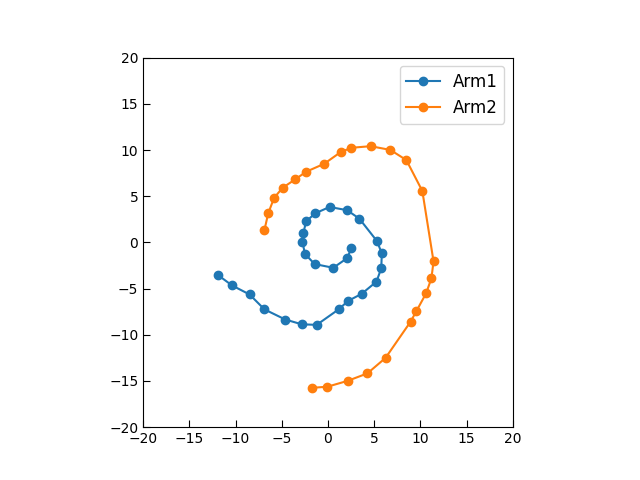

In [25]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig, ax = plt.subplots()
ax.plot(fits_arm1.x_tracing, fits_arm1.y_tracing, marker = 'o', label = 'Arm1')
ax.plot(fits_arm2.x_tracing, fits_arm2.y_tracing, marker = 'o', label = 'Arm2')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.legend()
ax.set_aspect('equal')

In [26]:
def calc_euclidean(x1,y1,x2,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [27]:
dist_previous = []
for i in range(len(df_tracing_arm2)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm2.iloc[i-1].x
        y1 = df_tracing_arm2.iloc[i-1].y
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))

In [28]:
df_tracing_arm2['dist_previous'] = dist_previous
df_tracing_arm2['arm_length'] = df_tracing_arm2.dist_previous.cumsum()



In [29]:
df_tracing_arm2.head(3)

,x,y,arm,id,dist_previous,arm_length
0,-6.875902,1.351010,2,0,7.007371,7.007371
1,-6.471861,3.140332,2,1,1.834372,8.841744
2,-5.836941,4.814214,2,2,1.790253,10.631996


In [30]:
def assign_length(id_tracing, df_tracing):
    length = df_tracing[df_tracing.id == id_tracing].arm_length.values[0]
    return length

In [31]:
fits_arm2['arm_length'] = fits_arm2.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm2), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
fits_arm2.head(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,...,y,y_tracing,arm,r_tracing,width_info,x_max,y_max,w1,w2,arm_length
26,0.000034,7.544319,0.05,False,-1.280062,0.0,1.081211,6.972993e-07,0.106043,0.383579,...,"[5.41416225299757e-06, 5.387739580185315e-06, ...",1.351010,2,7.007371,"{'x_max': 6.96489156368591, 'y_max': 1.6321714...",6.964892,0.000016,1.016777,0.920709,7.007371
27,0.000018,8.253373,0.05,False,-2.827778,1.0,1.380712,2.652489e-06,0.132261,2.284118,...,"[5.935527983386941e-06, 6.268813783770811e-06,...",3.140332,2,7.193516,"{'x_max': 7.585606195072613, 'y_max': 8.538028...",7.585606,0.000009,1.184281,0.781303,8.841744
28,0.000039,9.136066,0.05,False,-2.028356,2.0,2.180747,3.122419e-06,0.295650,1.479713,...,"[5.2367944488047285e-06, 7.2925853827430656e-0...",4.814214,2,7.566144,"{'x_max': 7.980992575553614, 'y_max': 1.068862...",7.980993,0.000011,1.903528,1.490348,10.631996


In [33]:
fits_arm2.to_csv(f'DATA/results/Halo_{id_halo}_Arm2_widths_Oct10.csv')

In [34]:
fits_arm2[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
26,0.000034,7.544319,-1.280062,0.0,1.081211,6.972993e-07,0.106043,2,7.007371,1.016777,0.920709,7.007371
27,0.000018,8.253373,-2.827778,1.0,1.380712,2.652489e-06,0.132261,2,7.193516,1.184281,0.781303,8.841744
28,0.000039,9.136066,-2.028356,2.0,2.180747,3.122419e-06,0.295650,2,7.566144,1.903528,1.490348,10.631996
29,0.000026,7.155127,1.374919,3.0,0.988382,1.407120e-06,0.225317,2,7.686376,0.815942,0.917105,12.065733
30,0.000035,8.593441,-2.371188,4.0,1.220056,2.057815e-06,0.099616,2,7.691359,1.052087,0.764459,13.730634
31,0.000039,7.728465,-0.009802,5.0,1.566642,5.853086e-06,36578.998429,2,8.002648,1.844362,1.844684,15.139760
32,0.000028,7.098618,1.831339,6.0,1.499379,2.057730e-06,0.261015,2,8.518231,1.080996,1.325100,17.284742
33,0.000042,10.983673,-5.929829,7.0,1.756504,1.941906e-06,0.057256,2,9.874769,1.595089,0.617459,19.478863
34,0.000039,10.107006,13.099572,8.0,1.103819,2.392408e-06,0.012739,2,10.548409,0.218918,1.105894,20.722191
35,0.000043,11.536088,0.000222,9.0,0.765785,5.643822e-06,270951.247861,2,11.388042,0.901925,0.901362,22.807316


(-1.0, 1.0)

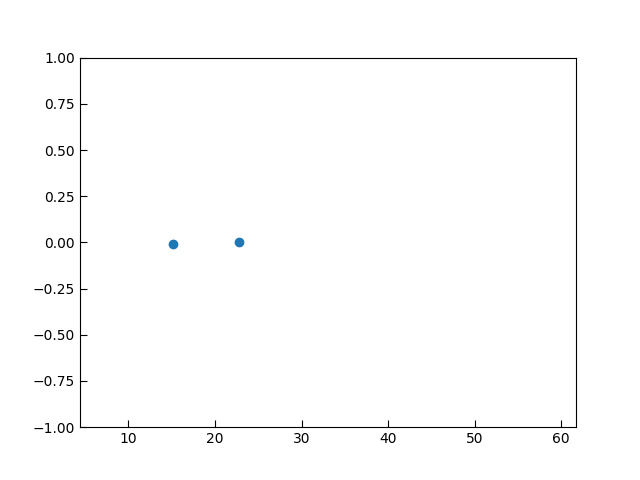

In [35]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm2.arm_length, fits_arm2.gamma)
ax.set_ylim(-1,1)

In [36]:
dist_previous = []
for i in range(len(df_tracing_arm1)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm1.iloc[i-1].x
        y1 = df_tracing_arm1.iloc[i-1].y
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))


df_tracing_arm1['dist_previous'] = dist_previous
df_tracing_arm1['arm_length'] = df_tracing_arm1.dist_previous.cumsum()

In [37]:
fits_arm1['arm_length'] = fits_arm1.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm1), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
fits_arm1.to_csv(f'DATA/results/Halo_{id_halo}_Arm1_widths_Oct10.csv')

In [39]:
fits_arm1[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
0,0.000012,2.708450,-2.897497,0.0,0.411402,8.693027e-07,0.021994,1,2.605243,0.352364,0.229967,2.605243
1,0.000014,2.416738,1.448791,1.0,0.520256,1.042213e-06,0.119084,1,2.684328,0.419311,0.478318,3.795172
2,0.000021,2.616503,3.564727,2.0,0.493153,1.674766e-06,0.034669,1,2.805623,0.241849,0.426316,5.620441
3,0.000028,2.459819,9.366087,3.0,1.139568,1.985699e-06,0.026092,1,2.755562,0.289453,1.097410,7.680651
4,0.000021,3.023343,-1.597062,4.0,0.378226,1.643474e-06,0.097818,1,2.783792,0.341490,0.291638,9.191329
5,0.000031,3.228970,-3.899095,5.0,0.737389,2.466026e-06,0.037225,1,2.778963,0.640316,0.342678,10.549898
6,0.000031,2.407776,4.979274,6.0,0.596533,1.245851e-06,0.016670,1,2.845601,0.236538,0.530109,11.480606
7,0.000040,2.839770,23.625737,7.0,1.397990,4.130055e-06,0.023410,1,3.287571,0.175255,1.482552,12.782830
8,0.000035,2.927822,2.537329,8.0,1.100390,2.361174e-06,0.089358,1,3.435219,0.663588,0.945646,14.091434
9,0.000030,4.839714,-1.043928,9.0,0.657878,1.580652e-06,0.214713,1,3.836563,0.644986,0.605335,15.796864


(-1.0, 1.0)

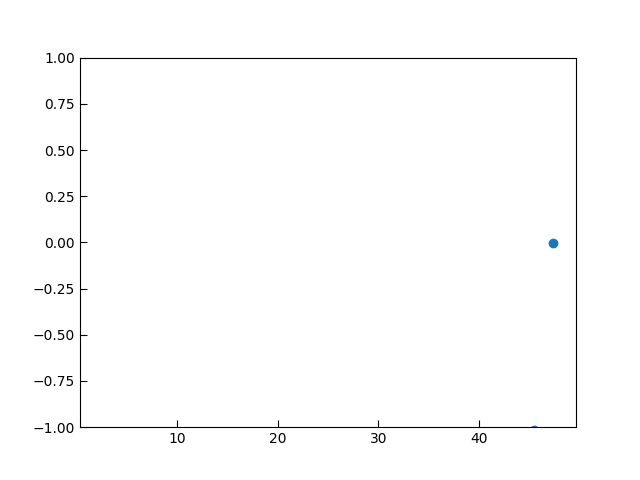

In [40]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm1.arm_length, fits_arm1.gamma)
ax.set_ylim(-1,1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-bc0a71f77a6b>", line 2, in <module>
    ax.plot(arm1.x_tracing, arm1.y_tracing)
NameError: name 'arm1' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/daniel

NameError: name 'arm1' is not defined

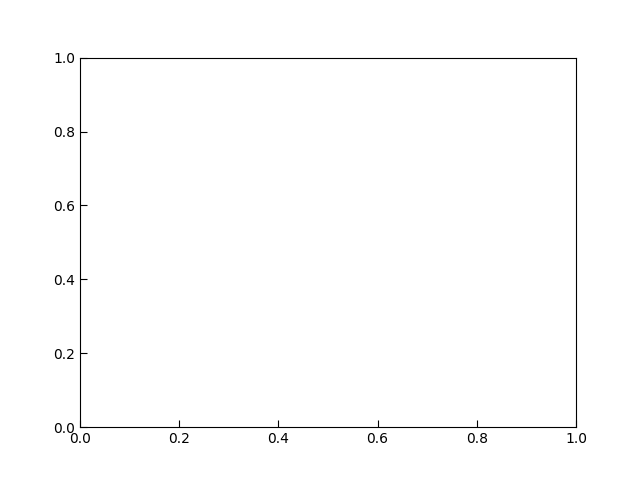

In [41]:
fig, ax = plt.subplots()
ax.plot(arm1.x_tracing, arm1.y_tracing)
ax.plot(arm2.x_tracing, arm2.y_tracing)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

In [ ]:
#df_fits.head
#print(df_fits["amplitude"], df_fits["center"], df_fits["sigma"],  df_fits["gamma"], df_fits["x_tracing"], df_fits["y_tracing"], df_fits["x_max"], df_fits["y_max"], df_fits["w1"], df_fits["w2"], df_fits["arm"], df_fits["fractured"])
#print(df_fits["w1"], df_fits["w2"])
#df_fits.to_csv('Arm_width_rho.csv')

In [ ]:
df_print = pd.DataFrame(zip(df_fits.amplitude, df_fits.center, df_fits.sigma, df_fits.gamma, df_fits.x_tracing, df_fits.y_tracing, df_fits.x_max, df_fits.y_max, df_fits.w1, df_fits.w2, df_fits.arm, df_fits.fractured, df_fits.id_tracing))


In [ ]:
df_print.to_csv('Arm2_widths_rho_adicionales_Ago4.csv')

In [ ]:
def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Verificar que x_eval y y_eval no estén vacíos
    if len(x_eval) == 0 or len(y_eval) == 0:
        print(f"Advertencia: 'x_eval' o 'y_eval' están vacíos para params id: {params.get('id_tracing', 'desconocido')}")
        return {'x_max': np.nan, 'y_max': np.nan, 'w1': np.nan, 'w2': np.nan}

    # Continúa si no están vacíos
    x_max, y_max = find_maximum(x_eval, y_eval)

    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []
    if isinstance(intersection, MultiPoint):
        points_intercept = list(intersection)
    elif not intersection.is_empty:
        points_intercept = [intersection]

    points_intercept = [[point.x, point.y] for point in points_intercept]

    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}



df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)